# GPA statistics

## Load `mean_shape`, model and dataset

In [1]:
import torch

from wings.config import PROCESSED_DATA_DIR, MODELS_DIR
from wings.modeling.litnet import LitNet
from wings.modeling.loss import DiceLoss

mean_coords = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "mean_shape.pth", weights_only=False
)

checkpoint_path = MODELS_DIR / 'unet-rectangle-epoch=08-val_loss=0.14-unet-training-rectangle_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()

test_dataset = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "test_mask_dataset.pth",
    weights_only=False
)
max_n = len(test_dataset)


2025-10-19 14:49:53.740 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-10-19 14:49:53.913 | INFO     | wings.config:<module>:62 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'
Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


## Preprocess data

In [2]:
from wings.gpa import recover_order
from wings.visualizing.image_preprocess import mask_to_coords, unet_reverse_padding
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

original_labels = []
predicted_labels = []
bad_masks = 0
bad_indices = []

for idx, (image, label, original_coords, orig_size) in enumerate(tqdm(test_dataset, desc="Evaluating")):
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        mask = torch.round(output).squeeze().cpu().numpy()

    try:
        mask_coords = mask_to_coords(mask, max_iter=1)
        mask_height, mask_width = mask.shape
        orig_width, orig_height = orig_size

        pad_left, pad_top, pad_right, pad_bottom = unet_reverse_padding(mask, orig_width, orig_height)
        mask_coords = [(x - pad_left, y - pad_bottom) for x, y in mask_coords]

        scale_x = orig_width / (mask_width - pad_right - pad_left)
        scale_y = orig_height / (mask_height - pad_top - pad_bottom)
        mask_coords_scaled = torch.tensor([(x * scale_x, y * scale_y) for x, y in mask_coords])

        reordered = recover_order(mean_coords, mask_coords_scaled)
        orig = original_coords.view(-1, 2)

        original_labels.append(orig.cpu().numpy())
        predicted_labels.append(reordered.cpu().numpy())

    except Exception as e:
        bad_masks += 1
        bad_indices.append(idx)
        continue

print(f"Total samples: {len(test_dataset)}")
print(f"Failed masks: {bad_masks}")

original_labels = np.stack(original_labels)
predicted_labels = np.stack(predicted_labels)

print(f"original_labels.shape = {original_labels.shape}")
print(f"predicted_labels.shape = {predicted_labels.shape}")


Evaluating: 100%|██████████| 2172/2172 [01:25<00:00, 25.45it/s] 

Total samples: 2172
Failed masks: 37
original_labels.shape = (2135, 19, 2)
predicted_labels.shape = (2135, 19, 2)


# Calculate Statistics

In [62]:
errors = np.linalg.norm(predicted_labels - original_labels, axis=2)  # shape: (n_samples, 19)
errors.size


40565

## Mean Error

### Per point

In [61]:
import pandas as pd

mean = errors.mean()
median = np.median(errors)

mean_error = errors.mean(axis=0)
min_error = errors.min(axis=0)
max_error = errors.max(axis=0)

rmse_error = np.sqrt(np.mean(errors ** 2, axis=0))
median_error = np.median(errors, axis=0)

df = pd.DataFrame(
    {
        "MAE": mean_error,
        "RMSE": rmse_error,
        "Median": median_error,
        "Min": min_error,
        "Max": max_error,
    }, index=np.arange(1, 20)
)

print(f"{mean=}")
print(f"{median=}\n")

df.index.name = "Point"
df = df.round(3)

print(df)


mean=np.float32(1.8126279)
median=np.float32(1.682673)

         MAE   RMSE  Median    Min         Max
Point                                         
1      1.921  2.142   1.879  0.014    6.574000
2      1.822  2.049   1.716  0.000    6.416000
3      1.731  4.046   1.572  0.038  165.785004
4      2.019  2.715   1.906  0.000   70.101997
5      1.906  2.142   1.804  0.041   10.984000
6      1.787  2.027   1.628  0.062    6.719000
7      1.706  1.902   1.637  0.000    6.193000
8      1.632  1.849   1.528  0.004    5.848000
9      1.638  1.847   1.530  0.037    5.979000
10     1.600  1.804   1.513  0.000    6.051000
11     1.638  1.854   1.535  0.059    6.205000
12     1.727  1.958   1.653  0.000    7.541000
13     1.862  2.104   1.740  0.000    8.372000
14     2.026  2.353   1.854  0.046    9.839000
15     1.636  1.853   1.515  0.000    6.956000
16     1.757  1.994   1.618  0.051    5.705000
17     1.834  2.094   1.685  0.000    6.368000
18     1.962  3.506   1.751  0.100  126.555000
19  

### Per image

In [63]:
mean_per_image = errors.mean(axis=1)
# mean_per_image = np.sqrt(np.mean(errors**2, axis=1))

mae = np.mean(np.abs(mean_per_image))
rmse = np.sqrt(np.mean(mean_per_image ** 2))
median_error = np.median(mean_per_image)
min_error = np.min(mean_per_image)
max_error = np.max(mean_per_image)

df = pd.DataFrame(
    {
        "MAE": [mae],
        "RMSE": [rmse],
        "Median": [median_error],
        "Min": [min_error],
        "Max": [max_error]
    }
).round(3)

print(df)


     MAE   RMSE  Median    Min    Max
0  1.813  1.886    1.72  1.052  14.59


## Images with the worst statistics

### Single point

In [6]:
import numpy as np

n = 10

flat_errors = errors.flatten()

# Get indices of top-n largest errors
top_n_flat_indices = np.argpartition(-flat_errors, n)[:n]
top_n_flat_indices = top_n_flat_indices[np.argsort(-flat_errors[top_n_flat_indices])]

# Convert back to 2D indices (sample index, inner index)
top_n_indices_2d = np.array(np.unravel_index(top_n_flat_indices, errors.shape)).T  # shape: (n, 2)
top_n_sample_indices = top_n_indices_2d[:, 0]

all_indices = list(range(len(test_dataset)))
good_indices = [i for i in all_indices if i not in bad_indices]

original_dataset_indices_per_point = [good_indices[i] for i in top_n_sample_indices]

print("Top-n errors (dataset_index, point, error_value):")
for idx, ((sample_idx, inner_idx), dataset_idx) in enumerate(zip(top_n_indices_2d, original_dataset_indices_per_point)):
    print(
        f"{idx + 1:2.0f}:\tIndex={dataset_idx:5.0f}\t\tPoint {inner_idx:2.0f}\tError={errors[sample_idx, inner_idx]:7.2f}"
    )

print(original_dataset_indices_per_point)


Top-n errors (dataset_index, point, error_value):
 1:	Index=  522		Point  2	Error= 165.78
 2:	Index= 1815		Point 17	Error= 126.55
 3:	Index=  522		Point  3	Error=  70.10
 4:	Index= 1350		Point 18	Error=  20.94
 5:	Index=  259		Point 17	Error=  16.12
 6:	Index=  284		Point  3	Error=  12.83
 7:	Index= 1732		Point  4	Error=  10.98
 8:	Index= 1409		Point 13	Error=   9.84
 9:	Index=  517		Point 13	Error=   9.63
10:	Index= 1117		Point 13	Error=   9.26
[522, 1815, 522, 1350, 259, 284, 1732, 1409, 517, 1117]


### Whole image mean

In [7]:
import numpy as np

n = 10

mean_errors_per_image = np.mean(errors, axis=1)  # shape: (n_images,)

top_n_indices = np.argpartition(-mean_errors_per_image, n)[:n]
top_n_indices = top_n_indices[np.argsort(-mean_errors_per_image[top_n_indices])]

all_indices = list(range(len(test_dataset)))
good_indices = [i for i in all_indices if i not in bad_indices]
original_dataset_indices_per_image = [good_indices[i] for i in top_n_indices]

print("Top-n images with largest mean error (dataset_index, mean_error):")
for rank, (sample_idx, dataset_idx) in enumerate(zip(top_n_indices, original_dataset_indices_per_image), start=1):
    print(f"{rank:2}: Index={dataset_idx:5}\t\tMean error={mean_errors_per_image[sample_idx]:7.3f}")


Top-n images with largest mean error (dataset_index, mean_error):
 1: Index=  522		Mean error= 14.590
 2: Index= 1815		Mean error=  9.979
 3: Index= 1782		Mean error=  4.754
 4: Index=  818		Mean error=  4.215
 5: Index= 2016		Mean error=  4.156
 6: Index= 1179		Mean error=  4.088
 7: Index= 1371		Mean error=  4.087
 8: Index=  189		Mean error=  3.909
 9: Index= 1792		Mean error=  3.810
10: Index= 1837		Mean error=  3.624


## Threshold

How many points are there, which have error greater than threshold and how many images are there that mean error on every point is greater than threshold

In [8]:
threshold = 3.5

num_errors_above_threshold = np.sum(errors > threshold)
total_points = errors.size
percentage = (num_errors_above_threshold / total_points) * 100

print(f"Number of points with error > {threshold}: {num_errors_above_threshold}")
print(f"Percent of all points: {percentage:.2f}%")


Number of points with error > 3.5: 2194
Percent of all points: 5.41%


### Threshold graph

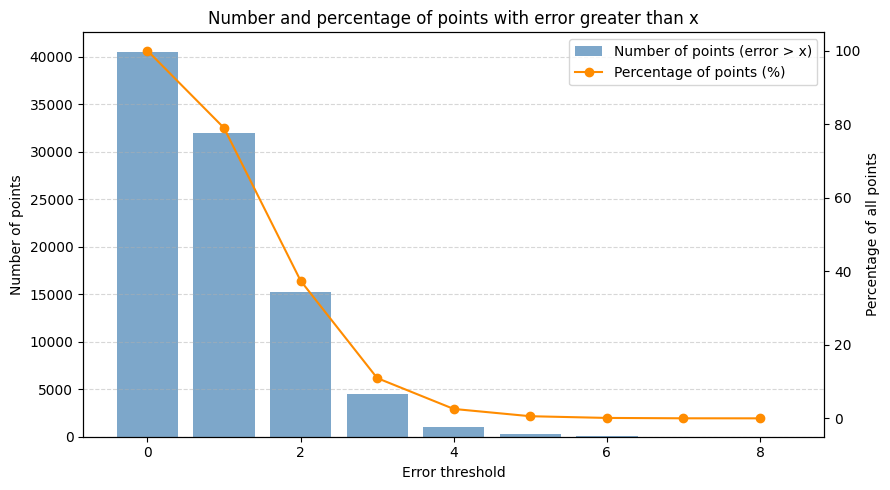

In [9]:
import numpy as np
import matplotlib.pyplot as plt

flat_errors = errors.flatten()
# m = int(np.ceil(flat_errors.max()))
m = 8

x_values = np.arange(0, m + 1)

counts = [np.sum(flat_errors > x) for x in x_values]
percentages = [100 * c / len(flat_errors) for c in counts]

# Graph
fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.bar(x_values, counts, color='steelblue', alpha=0.7, label='Number of points (error > x)')
ax1.set_xlabel('Error threshold')
ax1.set_ylabel('Number of points')
# ax1.set_yscale('log')  # logaritmic scale
ax1.grid(True, which="both", axis='y', linestyle='--', alpha=0.5)
ax1.set_title('Number and percentage of points with error greater than x')

ax2 = ax1.twinx()
ax2.plot(x_values, percentages, color='darkorange', marker='o', label='Percentage of points (%)')
ax2.set_ylabel('Percentage of all points')

# ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()


## Threshold graph per image

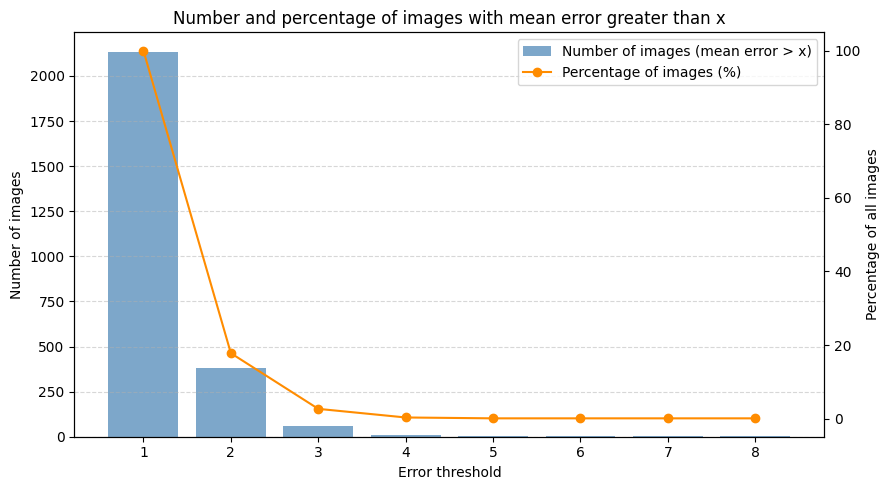

In [10]:
import numpy as np
import matplotlib.pyplot as plt

mean_errors_per_image = np.mean(errors, axis=1)

m = 8
x_values = np.arange(1, m + 1)

counts = [np.sum(mean_errors_per_image > x) for x in x_values]
percentages = [100 * c / len(mean_errors_per_image) for c in counts]

fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.bar(x_values, counts, color='steelblue', alpha=0.7, label='Number of images (mean error > x)')
ax1.set_xlabel('Error threshold')
ax1.set_ylabel('Number of images')
ax1.grid(True, which="both", axis='y', linestyle='--', alpha=0.5)
ax1.set_title('Number and percentage of images with mean error greater than x')

ax2 = ax1.twinx()
ax2.plot(x_values, percentages, color='darkorange', marker='o', label='Percentage of images (%)')
ax2.set_ylabel('Percentage of all images')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()


In [11]:
threshold = 3.5

mean_errors_per_image = np.mean(errors, axis=1)

num_images_above_threshold = np.sum(mean_errors_per_image > threshold)
total_images = len(mean_errors_per_image)
percentage = (num_images_above_threshold / total_images) * 100

print(f"Number of images with mean error > {threshold}: {num_images_above_threshold}")
print(f"Percent of all images: {percentage:.2f}%")


Number of images with mean error > 3.5: 13
Percent of all images: 0.61%


# PLOT image with predicted and original coordinates

In [12]:
values = original_dataset_indices_per_image
values_iter = iter(values)


2068


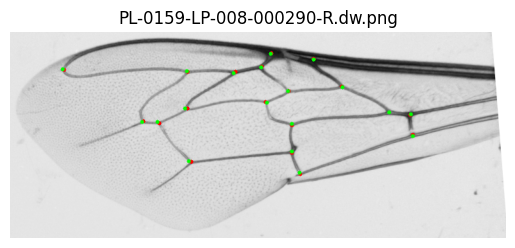

In [53]:
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import final_coords
import cv2
from wings.config import RAW_DATA_DIR, IMG_FOLDER_SUFX

n = np.random.randint(0, max_n)
# n = 522
# try:
#     n = next(values_iter)
# except StopIteration:
#     values_iter = iter(values)
#     n = next(values_iter)

image, _, coords, (x_size, y_size) = test_dataset[n]
original_dataset = test_dataset.dataset  # this gives you the original dataset
filename = original_dataset.coords_df.loc[test_dataset.indices[n], 'file']

country = filename.split('-', 1)[0]
imgpath = RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename
img = cv2.imread(imgpath, cv2.IMREAD_COLOR)

try:
    output = model(image.cuda().unsqueeze(0))
    mask = torch.round(output).squeeze().detach().cpu().numpy()

    mask_coords = final_coords(mask, x_size, y_size)

    flat_coords = [coord for pair in mask_coords for coord in pair]  # Flatten list of tuples
    target = torch.tensor(flat_coords, dtype=torch.float32)

    # Visualize
    spot_size = 3
    img = visualize_coords(img, coords, spot_size=spot_size, color=(255, 0, 0), show=False)
    print(n)
    img = visualize_coords(img, target, spot_size=spot_size, color=(0, 255, 0), filename=filename)
except Exception as e:
    plt.imshow(mask)
    plt.axis('off')
    plt.show()
    print(e)
